<a href="https://colab.research.google.com/github/vladi29/ANA-Classifier/blob/main/basic_level_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Universidad Simon Bolivar - 26 de Enero de 2022
# Trabajo final de grado: Clasificador de patrones ANA
# Vladimir Alfaro - 1510023

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os
import time
import h5py

device = "cuda" if torch.cuda.is_available() else "cpu"

# Cleaning the VRAM memory
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device=None)
#print("Espacio disponible en GPU (Gb): ", torch.cuda.memory_allocated()*1e-9)

  # Accuracy = TP + TN / (TP + TN + FP + FN)
  # Precision = TP / (TP + FP)
  # Recall = TP / (TP + FN) 
  # F1 = 2 * (Precision * Recall) / (Precision + Recall)
  
#y_true = [[1, 0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0]]
#y_pred = [[1, 0, 0, 1], [0, 1, 0, 0], [0, 1, 1, 0]]
#precision_score(y_true, y_pred, average='weighted', zero_division=1)
#recall_score(y_true, y_pred, average='weighted', zero_division=1)
#f1_score(y_true, y_pred, average='weighted', zero_division=0)

In [2]:
#----------Paths----------

images_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Augmented_dataset/'
original_labels_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/original_labels.csv'
original_names_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/original_names.csv'
augmented_labels_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/augmented_labels.csv'
augmented_names_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/augmented_names.csv'
original_ds_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/Original_dataset.h5'
augmented_ds_path =r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/Augmented_dataset.h5'

original_names = pd.read_csv(original_names_path, header = None)
original_names = original_names.values.tolist()

labels_raw = pd.read_csv(original_labels_path, header = None)
labels_raw = labels_raw.values.tolist()
original_labels = []
for label in labels_raw:
  original_labels.append(label[0])

augmented_names = pd.read_csv(augmented_names_path, header = None)
augmented_names = augmented_names.values.tolist()

labels_raw = pd.read_csv(augmented_labels_path, header = None)
labels_raw = labels_raw.values.tolist()
augmented_labels = []
for label in labels_raw:
  augmented_labels.append(label[0])


Etiquetas divididas para cada muestra:  [['FewNuclearDots', 'FineSpeckled'], ['Negative'], ['FineSpeckled', 'CytoplasmicReticularAMA'], ['Negative'], ['Centromere'], ['FineSpeckled', 'CytoplasmicFibrillar'], ['NuclearHomogeneous', 'MultipleNuclearDots'], ['Negative'], ['FineSpeckled', 'FewNuclearDots', 'NUMA-1MSA-1'], ['Negative'], ['Negative'], ['NuclearHomogeneous', 'NucleolarClumpy'], ['Negative'], ['FineSpeckled', 'NucleolarClumpy'], ['NUMA-1MSA-1'], ['Negative'], ['Negative'], ['Negative'], ['NuclearHomogeneous', 'NucleolarClumpy'], ['NucleolarClumpy'], ['NuclearMembranepores'], ['Negative'], ['NucleolarClumpy', 'FineSpeckled', 'CytoplasmicReticularAMA'], ['Negative'], ['FineSpeckled', 'CytoplasmicSpeckled'], ['NuclearHomogeneous', 'FewNuclearDots'], ['CoarseSpeckled', 'CytoplasmicSpeckled'], ['NUMA-1MSA-1'], ['Negative'], ['NuclearHomogeneous', 'FineSpeckled'], ['FewNuclearDots', 'FineSpeckled'], ['CytoplasmicPolarGolgiLike'], ['NuclearHomogeneous', 'CytoplasmicReticularAMA'], [

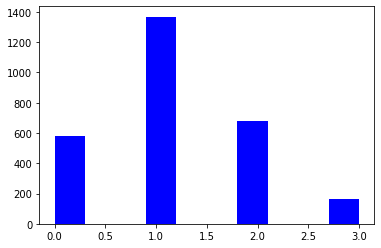


Etiquetas divididas para cada muestra:  [['FewNuclearDots', 'FineSpeckled'], ['FewNuclearDots', 'FineSpeckled'], ['FewNuclearDots', 'FineSpeckled'], ['FewNuclearDots', 'FineSpeckled'], ['FewNuclearDots', 'FineSpeckled'], ['Negative'], ['Negative'], ['Negative'], ['Negative'], ['Negative'], ['FineSpeckled', 'CytoplasmicReticularAMA'], ['FineSpeckled', 'CytoplasmicReticularAMA'], ['FineSpeckled', 'CytoplasmicReticularAMA'], ['FineSpeckled', 'CytoplasmicReticularAMA'], ['FineSpeckled', 'CytoplasmicReticularAMA'], ['Negative'], ['Negative'], ['Negative'], ['Negative'], ['Negative'], ['Centromere'], ['Centromere'], ['Centromere'], ['Centromere'], ['Centromere'], ['FineSpeckled', 'CytoplasmicFibrillar'], ['FineSpeckled', 'CytoplasmicFibrillar'], ['FineSpeckled', 'CytoplasmicFibrillar'], ['FineSpeckled', 'CytoplasmicFibrillar'], ['FineSpeckled', 'CytoplasmicFibrillar'], ['NuclearHomogeneous', 'MultipleNuclearDots'], ['NuclearHomogeneous', 'MultipleNuclearDots'], ['NuclearHomogeneous', 'Multi

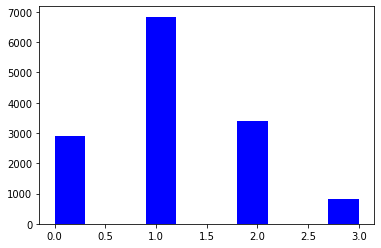

In [3]:
#----------Etiquetado de cada imagen----------

def Labeling(label_list):

  split_labels = []
  basic_level_labels_raw = []
  basic_level_labels = []
  basic_level_labels_to_model = []

  for label in label_list: # Separamos las etiquetas para cada muestra
    split_labels.append(label.split("_"))

  for label in split_labels:
    group = []
    for basic_label in label:
      if (basic_label == "NuclearHomogeneous" or basic_label == "DSF-70" or basic_label == "Centromere" or 
          basic_label == "FineSpeckled" or basic_label == "CoarseSpeckled" or basic_label == "MultipleNuclearDots" or
          basic_label == "FewNuclearDots" or basic_label == "NucleolarHomogeneous" or basic_label == "NucleolarClumpy" or
          basic_label == "NucleolarSpeckled" or basic_label == "NuclearMembranous" or basic_label == "NuclearMembranepores" or
          basic_label == "PCNA" or basic_label == "PCNA(ProliferatingCellNuclearAntigen)" or basic_label == "SCl-70"):  # Hay algunas imagenes con la etiqueta PCNA(ProliferatingCellNuclearAntigen)
        group.append(1)
      elif (basic_label == "CytoplasmicSpeckled" or basic_label == "CytolplasmicSpeckled" or basic_label == "CytoplasmicFibrillar" or # Hay algunas imagenes con la etiqueta CytolplasmicSpeckled
            basic_label == "CytoplasmicReticularAMA" or basic_label == "CytoplasmicPolarGolgiLike" or basic_label == "Tubulin"):
        group.append(2)
      elif (basic_label == "Centriole" or basic_label == "NUMA-1MSA-1" or basic_label == "Midbody(MSA-2)"):
        group.append(3)
      elif (basic_label == "Negative"):
        group.append(0)
      else:
        print("LOS QUE FALTAN: ", basic_label)
    
    basic_level_labels_raw.append(group)

  for group in basic_level_labels_raw:
    basic_level_labels.append(list(set(group)))

  for group in basic_level_labels:
    total_label_group = [0, 0, 0, 0]
    for clase in group:
      total_label_group[clase] = 1
    basic_level_labels_to_model.append(total_label_group)

  print("\nEtiquetas divididas para cada muestra: ", split_labels)
  print("Etiquetas traducidas a los 4 grandes grupos: ", basic_level_labels_raw)
  print("Etiquetas traducidas a los 4 grandes grupos (sin valores repetidos): ", basic_level_labels)
  print("\nEtiquetas finales para el modelo: ", basic_level_labels_to_model)
  print("Tamano de arreglo de etiquetas finales: ", len(basic_level_labels_to_model))

  return basic_level_labels_to_model

#----------Pesos e histograma de labels----------

def Weights_and_Histogram(basic_level_labels):

  Negatives = 0
  Nuclear = 0
  Cytoplasmic = 0
  Mitotic = 0
  weights, histogram_data = [], []

  for labels in basic_level_labels:  
    if labels[0] == 1:
      Negatives += 1
      histogram_data.append(0)
    if labels[1] == 1:
      Nuclear += 1
      histogram_data.append(1)
    if labels[2] == 1:
      Cytoplasmic += 1
      histogram_data.append(2)
    if labels[3] == 1:
      Mitotic += 1
      histogram_data.append(3)

  # Creacion de un vector de pesos para balancear las clases
  weights.append(Negatives)
  weights.append(Nuclear)
  weights.append(Cytoplasmic)
  weights.append(Mitotic)
  weights = np.array(weights)
  weights = 1/weights
  weights = weights/np.sum(weights)
  weights = torch.tensor(weights, dtype=torch.float)
  print(weights.type())

  print("Negativos: ", Negatives, "\nNuclear: ", Nuclear,
        "\nCitoplasmaticos: ", Cytoplasmic, "\nMitotico: ", Mitotic)
  print("Pesos de cada clase: ", weights)
  plt.hist(histogram_data, facecolor = 'blue', alpha = 1)
  plt.show()

  return weights

original_labels = Labeling(original_labels)
original_weights = Weights_and_Histogram(original_labels)

augmented_labels = Labeling(augmented_labels)
augmented_weights = Weights_and_Histogram(augmented_labels)


In [4]:
#----------Creacion de datasets----------

x_train, x_val_test, y_train, y_val_test = train_test_split(original_names, original_labels, test_size = 0.3, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.5, random_state = 42)

A_x_train, A_x_val_test, A_y_train, A_y_val_test = train_test_split(augmented_names, augmented_labels, test_size = 0.3, random_state = 42)
A_x_val, A_x_test, A_y_val, A_y_test = train_test_split(A_x_val_test, A_y_val_test, test_size = 0.5, random_state = 42)

tensor([0, 1, 0, 0])


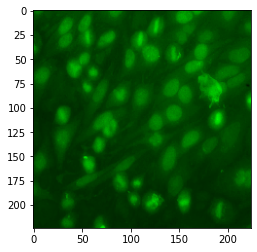

tensor([0, 1, 1, 0])


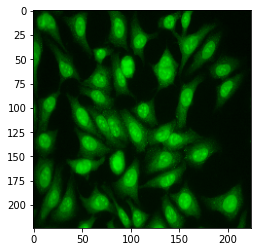

tensor([0, 1, 0, 0])


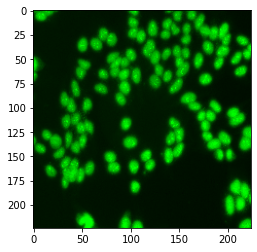

In [5]:
#----------Clase Dataset Personaliazdo----------

Custom_transform = transforms.Compose([ 
    transforms.CenterCrop((200, 200)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]) # No hay cambios. i = (i - mean)/std
])

class CustomImageDataset(Dataset):
    def __init__(self, dataset, names, labels, transform=None):
        self.dataset = dataset
        self.names = names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_name = self.names[idx][0].split('.')[0]
        image = self.dataset.get(image_name)[:] 
        image = torch.tensor(image)  
        label = torch.tensor(self.labels[idx])    

        if self.transform:
            image = self.transform(image)
        
        return image, label

# Creando Dataloader para los conjuntos de entrenamiento y prueba
original_dataset = h5py.File(original_ds_path, 'r')
augmented_dataset = h5py.File(augmented_ds_path, 'r')

Batch_size = 64

train_data = CustomImageDataset(original_dataset, x_train, y_train) # transform=Custom_transform
train_dataloader = DataLoader(train_data, batch_size=Batch_size, shuffle=True, num_workers=2)   #-------------------------Cambiar el shuffle-----------------------

val_data = CustomImageDataset(original_dataset, x_val, y_val)
val_dataloader = DataLoader(val_data, batch_size=Batch_size, shuffle=True, num_workers=2)       #-------------------------Cambiar el shuffle----------------------- 

test_data = CustomImageDataset(original_dataset, x_test, y_test)
test_dataloader = DataLoader(test_data, batch_size=Batch_size, shuffle=False, num_workers=2)    #-------------------------Cambiar el shuffle-----------------------

images, labels = next(iter(train_dataloader))
plt.imshow(images[0])
print(labels[0])
plt.show()

images, labels = next(iter(val_dataloader))
plt.imshow(images[0])
print(labels[0])
plt.show()

images, labels = next(iter(test_dataloader))
plt.imshow(images[0])
print(labels[0])
plt.show()

In [6]:
# Creacion de la InmunoNet

class InmunoNet(nn.Module):
  def __init__(self, numChannels, numClasses):
    super(InmunoNet, self).__init__()

    self.numChannels = numChannels
    self.numClasses = numClasses

    # Se inicializa la primera capa convolucional (CONV => RELU => POOL layers)
    self.conv1 = nn.Conv2d(in_channels = numChannels, out_channels = 96, kernel_size = (4, 4), stride = (4, 4),
                           padding = (2, 2)) # 3 canales de entrada y 32 de salida
    self.batchNorm1 = nn.BatchNorm2d(96)
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=1 , padding = 0)

    # Se inicializa la segunda capa convolucional (CONV => RELU => POOL layers)
    self.conv2 = nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size = (2, 2), stride = (1, 1),
                           padding = (2, 2)) # 64 canales de entrada y 64 de salida
    self.batchNorm2 = nn.BatchNorm2d(256)
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2 , padding =1)

    # Se inicializa la tercera capa convolucional (CONV => RELU => POOL layers)
    self.conv3 = nn.Conv2d(in_channels = 256, out_channels = 384, kernel_size = (2, 2), stride = (2, 2),
                           padding = (2, 2)) # 64 canales de entrada y 64 de salida
    self.batchNorm3 = nn.BatchNorm2d(384)
    self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2 , padding = 1)

    # Se inicializa la cuarta capa convolucional (CONV => RELU => POOL layers)
    self.conv4 = nn.Conv2d(in_channels = 384, out_channels = 384, kernel_size = (3, 3), stride = (1, 1),
                           padding = (1, 1)) # 64 canales de entrada y 128 de salida
    self.batchNorm4 = nn.BatchNorm2d(384)
    self.maxpool4 = nn.MaxPool2d(kernel_size = (3, 3), stride = (2, 2), padding = (1,1))

    # Se inicializa la capa convolucional de salida (CONV => RELU => POOL layers)
    self.convOut = nn.Conv2d(in_channels = 384, out_channels = 256, kernel_size = (5, 5), stride = (1, 1),
                           padding = (1, 1)) # 64 canales de entrada y 128 de salida
    #self.batchNormOut = nn.BatchNorm2d(256)
    self.maxpoolOut = nn.MaxPool2d(kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))

    # initialize first set of FC => RELU layers
    self.fc1 = nn.Linear(in_features = 50176, out_features = 10000)

    # initialize second set of FC => RELU layers
    self.fc2 = nn.Linear(in_features = 10000, out_features = 5000)

    # initialize third set of FC => RELU layers
    self.fc3 = nn.Linear(in_features = 5000, out_features = 1000)

    # initialize fouth set of FC => RELU layers
    self.fc4 = nn.Linear(in_features = 1000, out_features = 500)

    # Final set of FC
    self.fcout = nn.Linear(in_features = 500, out_features = numClasses)
    
    # Activation functions
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    
    # Regularization
    self.dropout = nn.Dropout(0.4) # Dropout con 40% de porbabilidades de desactivar cada neuronar
    self.conv_dropout = nn.Dropout(0.3) # Dropout de 40% para las capas convolucionales

  def forward(self, x):

    # Modificando el orden de los tensores (batch, canales, alto, ancho)
    x = x.permute(0, 3, 1, 2)

    # pass the input through our first set of CONV => RELU => POOL layers
    x = self.conv1(x)
    x = self.batchNorm1(x)
    x = self.relu(x)
    x = self.maxpool1(x)
    #print('Dimension 1:', x.size())

    # pass the output from the previous layer through the second set of CONV => RELU => POOL layers
    x = self.conv2(x)
    x = self.batchNorm2(x)
    x = self.relu(x)
    x = self.maxpool2(x)
    #print('Dimension 2:', x.size())

    # pass the output from the previous layer through the third set of CONV => RELU => POOL layers
    x = self.conv3(x)
    #x = self.batchNorm3(x)
    x = self.relu(x)
    #x = self.maxpool3(x)
    #print('Dimension 3:', x.size())

    # pass the output from the previous layer through the fourth set of CONV => RELU => POOL layers
    x = self.conv4(x)
    #x = self.batchNorm4(x)
    x = self.relu(x)
    #x = self.maxpool4(x)
    #print('Dimension 4:', x.size())

    # pass the output from the previous layer through the fourth set of CONV => RELU => POOL layers
    x = self.convOut(x)
    #x = self.conv_dropout(x)
    #x = self.batchNormOut(x)
    x = self.relu(x)
    x = self.maxpoolOut(x)
    #print('Dimension final:', x.size())

    # flatten the output from the previous layer and pass it through our first set of FC => RELU layers
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.dropout(x)
    x = self.relu(x)
    
    # pass the output from the previous layer through our second set of FC => RELU layers
    x = self.fc2(x)
    x = self.dropout(x)
    x = self.relu(x)

    # pass the output from the previous layer through our third set of FC => RELU layers
    x = self.fc3(x)
    x = self.dropout(x)
    x = self.relu(x)

    # pass the output from the previous layer through our third set of FC => RELU layers
    x = self.fc4(x)
    x = self.dropout(x)
    x = self.relu(x)

    # pass the output to our softmax classifier to get our output predictions
    x = self.fcout(x)
    output = x
    #output = self.sigmoid(x)  
    
    # return the output predictions
    return output

model = InmunoNet(3, 4)
#print('Modelo: \n', model)

# Viendo las dimensiones de cada feature map

#images, labels = next(iter(train_dataloader))
#print(images.size())
#print(labels.size())
#Y = model(images.float())



In [7]:
# Clase para adaptar modelo pre-entrenados

class MyExtendedNet(nn.Module):
    def __init__(self, pretrained_model):
        super(MyExtendedNet, self).__init__()
        self.pretrained = pretrained_model
        self.new_layer = nn.Sequential(nn.Linear(1000, 1000),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(1000, 500),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(500, 100),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(100, 10),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(10, 4), # nn.Linear(10, 1), para BCELoss
                                         #nn.Sigmoid()      # Para BCELoss
                                         )     
    
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.pretrained(x)
        x = self.new_layer(x)
        return x

In [8]:
# Funcion para el entrenamiento y validacion de la red

def train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs, device):
  # Inicializamos dos arreglos para guardar el costo por epoca para el entrenamiento y la validacion
  training_cost = []
  validation_cost = []
  aux_acc = 0.5
  
  for epoch in range(epochs):
    # Se inicializan la perdida del entrenamientos y de la validacion en 0
    training_batch_loss = []
    validation_batch_loss = []
    
    # Empieza el entrenamiento de la red
    model.train()
    Y_total = torch.ones((1,4)).to(device, torch.float32)      # Variable auxiliar para guardar todas las salidas
    Y_hat_total = torch.ones((1,4)).to(device, torch.float32)  # Variable auxiliar para guardar todas las salidas que predice el modelo
    for batch in iter(train_loader):
      X, Y = batch
      X = X.to(device, torch.float32)
      Y = Y.reshape((len(Y), 4))
      Y = Y.to(device, torch.float32)
      Y_hat = model(X)
      loss = loss_fn(Y_hat, Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      training_batch_loss.append(loss.data.item())     #-------------------------------------------Mover a la linea 25-----------------------
      Y_total = torch.cat((Y_total, Y), dim = 0)              # Concatenamos las salidas de cada lote
      Y_hat_total = torch.cat((Y_hat_total, Y_hat), dim = 0)  # Concatenamos las salidas que predice el modelo de cada lote
    training_cost_epoch = np.mean(training_batch_loss)
    training_cost.append(training_cost_epoch)          #-------------------------------------------La media de este vector es el coste por epoca-----------------------
    Y_total = Y_total[1:]                                     # Retiramos el primer valor del tensor ya que es un 1
    Y_hat_total = Y_hat_total[1:]                             # Retiramos el primer valor del tensor ya que es un 1
    Y_hat_total[Y_hat_total > 0.8] = 1
    Y_hat_total[Y_hat_total < 1] = 0
    #print("Prediccion entrenamiento: \n", Y_hat_total)
    
    # Metricas
    # GPU
    if (device == "cuda"):
      training_epoch_acc = accuracy_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
      training_epoch_pre = precision_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy(), average='weighted', zero_division=1)
      training_epoch_recall = recall_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy(), average='weighted', zero_division=1)
      training_epoch_F1 = f1_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy(), average='weighted', zero_division=0) 
    # CPU
    else:
      training_epoch_acc = accuracy_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
      training_epoch_pre = precision_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy(), average='weighted', zero_division=1)
      training_epoch_recall = recall_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy(), average='weighted', zero_division=1)
      training_epoch_F1 = f1_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy(), average='weighted', zero_division=0)

    # Empieza la validacion de la red
    model.eval()
    Y_total = torch.ones((1,4)).to(device, torch.float32)      # Variable auxiliar para guardar todas las salidas
    Y_hat_total = torch.ones((1,4)).to(device, torch.float32)  # Variable auxiliar para guardar todas las salidas que predice el modelo
    
    with torch.no_grad():
      for batch in iter(val_loader):
        X, Y = batch
        X = X.to(device, torch.float32)
        Y = Y.reshape((len(Y), 4))
        Y = Y.to(device, torch.float32)
        Y_hat = model(X)
        loss = loss_fn(Y_hat, Y)
        validation_batch_loss.append(loss.data.item())      
        Y_total = torch.cat((Y_total, Y), dim = 0)              # Concatenamos las salidas de cada lote
        Y_hat_total = torch.cat((Y_hat_total, Y_hat), dim = 0)  # Concatenamos las salidas que predice el modelo de cada lote
      validation_cost_epoch = np.mean(validation_batch_loss)
      validation_cost.append(validation_cost_epoch)
      Y_total = Y_total[1:]           # Retiramos el primer valor del tensor ya que es un 1
      Y_hat_total = Y_hat_total[1:]   # Retiramos el primer valor del tensor ya que es un 1
      Y_hat_total[Y_hat_total > 0.8] = 1
      Y_hat_total[Y_hat_total < 1] = 0
      #print("Prediccion validacion: \n", Y_hat_total)
      
      # Metricas
      # GPU
      if (device == "cuda"):
        validation_epoch_acc = accuracy_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
        validation_epoch_pre = precision_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy(), average='weighted', zero_division=1)
        validation_epoch_recall = recall_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy(), average='weighted', zero_division=1)
        validation_epoch_F1 = f1_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy(), average='weighted', zero_division=0) 
      # CPU
      else:
        validation_epoch_acc = accuracy_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
        validation_epoch_pre = precision_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy(), average='weighted', zero_division=1)
        validation_epoch_recall = recall_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy(), average='weighted', zero_division=1)
        validation_epoch_F1 = f1_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy(), average='weighted', zero_division=0)
    
    # Guardando los parametros del modelo segun la exactitud de la validacion (Accuracy)
    if( validation_epoch_acc > aux_acc):
      torch.save(model.state_dict(), 'drive/MyDrive/Colab_Notebooks/Tesis/Models/Basic_level_model.pt')
      aux_acc = validation_epoch_acc
      print("Modelo guardado con Accuracy = ", aux_acc, "\n")
    
    # Imprimiendo datos del modelos
    print("Epoca: ", (epoch + 1), "/", epochs)
    print("Costo de entrenamiento ", round(training_cost_epoch, 5))
    print("Costo de validacion ", round(validation_cost_epoch, 5))
    print("Metricas del entrenmaiento:\n", "Exactitud: ", round(training_epoch_acc, 2), " Precision: ",
          round(training_epoch_pre, 2), " Recall: ", round(training_epoch_recall, 2), " F1: ", round(training_epoch_F1, 2))
    print("Metricas de la validacion:\n", "Exactitud: ", round(validation_epoch_acc, 2), " Precision: ",
          round(validation_epoch_pre, 2), " Recall: ", round(validation_epoch_recall, 2), " F1: ", round(validation_epoch_F1, 2), "\n")
  
  return training_cost, validation_cost   

  # Accuracy = TP + TN / (TP + TN + FP + FN)
  # Precision = TP / (TP + FP)
  # Recall = TP / (TP + FN) 
  # F1 = 2 * (Precision * Recall) / (Precision + Recall)

In [9]:
def train_model_2(model, optimizer, loss_fn, train_dataloader, val_dataloader, epochs, device):
    
    model.to(device)

    training_loss, validation_loss = [], []

    for epoch in range(0, epochs):
        model.train()
        train_loss, train_acc, train_prec, train_recall, train_f1 = [], [], [], [], []
        for batch in iter(train_dataloader):
            X, Y = batch
            X, Y = X.to(device, torch.float32), Y.to(device, torch.float32)
            optimizer.zero_grad()
            Y_hat = model(X)
            loss = loss_fn(Y_hat, Y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
            Y_hat[Y_hat > 0.5] = 1
            Y_hat[Y_hat < 1] = 0
            
            # Metricas
            # GPU
            if (device == "cuda"):
              acc = accuracy_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy())
              prec = precision_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average='weighted', zero_division=1)
              recall = recall_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average='weighted', zero_division=1)
              f1 = f1_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average='weighted', zero_division=0) 
            # CPU
            else:
              acc = accuracy_score(Y.detach().numpy(), Y_hat.detach().numpy())
              prec = precision_score(Y.detach().numpy(), Y_hat.detach().numpy(), average='weighted', zero_division=1)
              recall = recall_score(Y.detach().numpy(), Y_hat.detach().numpy(), average='weighted', zero_division=1)
              f1 = f1_score(Y.detach().numpy(), Y_hat.detach().numpy(), average='weighted', zero_division=0)
            
            train_acc.append(acc)
            train_prec.append(prec) 
            train_recall.append(recall)
            train_f1.append(f1)
        
        model.eval()
        val_loss, val_acc, val_prec, val_recall, val_f1 = [], [], [], [], []
        with torch.no_grad():
            for batch in iter(val_dataloader):
                X, Y = batch
                X, Y = X.to(device, torch.float32), Y.to(device, torch.float32)
                Y_hat = model(X)
                loss = loss_fn(Y_hat, Y)
                val_loss.append(loss.item())
                
                Y_hat[Y_hat > 0.5] = 1
                Y_hat[Y_hat < 1] = 0

                # Metricas
                # GPU
                if (device == "cuda"):
                  acc = accuracy_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy())
                  prec = precision_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average='weighted', zero_division=1)
                  recall = recall_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average='weighted', zero_division=1)
                  f1 = f1_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average='weighted', zero_division=0) 
                # CPU
                else:
                  acc = accuracy_score(Y.detach().numpy(), Y_hat.detach().numpy())
                  prec = precision_score(Y.detach().numpy(), Y_hat.detach().numpy(), average='weighted', zero_division=1)
                  recall = recall_score(Y.detach().numpy(), Y_hat.detach().numpy(), average='weighted', zero_division=1)
                  f1 = f1_score(Y.detach().numpy(), Y_hat.detach().numpy(), average='weighted', zero_division=0)
                
                val_acc.append(acc)
                val_prec.append(prec) 
                val_recall.append(recall)
                val_f1.append(f1)
        
        print(f"Epoca:{epoch + 1}/{epochs} \n")
        print(f"train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f} \n")
        print(f"train acc: {np.mean(train_acc):.5f}, val acc: {np.mean(val_acc):.5f} \n")
        print(f"train prec: {np.mean(train_prec):.5f}, val prec: {np.mean(val_prec):.5f} \n")
        print(f"train recall: {np.mean(train_recall):.5f}, val recall: {np.mean(val_recall):.5f} \n")
        print(f"train f1: {np.mean(train_f1):.5f}, val f1: {np.mean(val_f1):.5f} \n")
      
        training_loss.append(np.mean(train_loss))
        validation_loss.append(np.mean(val_loss))
         
    return training_loss, validation_loss


In [10]:
def test_model(model, test_loader, device):
  
  # Cargando el modelo con mayor exactitud en el set de validacion
  model.load_state_dict(torch.load('drive/MyDrive/Colab_Notebooks/Tesis/Models/Basic_level_model.pt'))
  print("Modelo cargado.\n")
  #print(torch.load('drive/MyDrive/Colab_Notebooks/Tesis/Models/Basic_level_model.pt'))
  
  # Empieza la prueba del modelo
  model.eval()
  Y_total = torch.ones((1,4)).to(device, torch.float32)      # Variable auxiliar para guardar todas las salidas
  Y_hat_total = torch.ones((1,4)).to(device, torch.float32)  # Variable auxiliar para guardar todas las salidas que predice el modelo
  for batch in iter(test_loader):
    X, Y = batch
    X = X.to(device, torch.float32)
    Y = Y.reshape((len(Y), 4))
    Y = Y.to(device, torch.float32)
    Y_hat = model(X)
    Y_total = torch.cat((Y_total, Y), dim = 0)               # Concatenamos las salidas de cada lote
    Y_hat_total = torch.cat((Y_hat_total, Y_hat), dim = 0)   # Concatenamos las salidas que predice el modelo de cada lote
  Y_total = Y_total[1:]           # Retiramos el primer valor del tensor ya que es un 1
  Y_hat_total = Y_hat_total[1:]   # Retiramos el primer valor del tensor ya que es un 1
  Y_hat_total[Y_hat_total > 0.8] = 1
  Y_hat_total[Y_hat_total < 1] = 0
  
  # Metricas
  # GPU
  if (device == "cuda"):
    test_acc = accuracy_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy())
    test_pre = precision_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy(), average='weighted', zero_division=1)
    test_recall = recall_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy(), average='weighted', zero_division=1)
    test_F1 = f1_score(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy(), average='weighted', zero_division=0) 
    test_confusion_matrix = multilabel_confusion_matrix(Y_total.cpu().detach().numpy(), Y_hat_total.cpu().detach().numpy()) 
  # CPU
  else:
    test_acc = accuracy_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy())
    test_pre = precision_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy(), average='weighted', zero_division=1)
    test_recall = recall_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy(), average='weighted', zero_division=1)
    test_F1 = f1_score(Y_total.detach().numpy(), Y_hat_total.detach().numpy(), average='weighted', zero_division=0)
    test_confusion_matrix = multilabel_confusion_matrix(Y_total.detach().numpy(), Y_hat_total.detach().numpy())

  #print("Y: ", Y)
  #print("Y_hat: ", Y_hat_total)
  return test_acc, test_pre, test_recall, test_F1, test_confusion_matrix


In [11]:
def test_model_2(model, test_loader, device):
    
    #model.load_state_dict(torch.load('drive/MyDrive/Colab_Notebooks/Tesis/Models/Basic_level_model.pt', map_location=device))
    #print("Modelo cargado.\n")
    
    model.to(device)
    average = 'weighted'
    model.eval()
    test_loss, test_acc, test_prec, test_recall, test_f1 = [], [], [], [], []
    with torch.no_grad():
        for batch in iter(test_dataloader):
            X, Y = batch
            X, Y = X.to(device, torch.float32), Y.to(device, torch.float32)
            Y_hat = model(X)

            Y_hat[Y_hat > 0.5] = 1
            Y_hat[Y_hat < 1] = 0

            # Metricas
            # GPU
            if (device == torch.device('cuda:0')):
              acc = accuracy_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy())
              prec = precision_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=1)
              recall = recall_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=1)
              f1 = f1_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0) 
            # CPU
            else:
              acc = accuracy_score(Y.detach().numpy(), Y_hat.detach().numpy())
              prec = precision_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=1)
              recall = recall_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=1)
              f1 = f1_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)
            
            test_acc.append(acc)
            test_prec.append(prec) 
            test_recall.append(recall)
            test_f1.append(f1)
    
    return(np.mean(test_acc), np.mean(test_prec), np.mean(test_recall), np.mean(test_f1))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 7.0 MB/s 


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/inception_resnet_v2-940b1cd6.pth" to /root/.cache/torch/hub/checkpoints/inception_resnet_v2-940b1cd6.pth
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoca:1/100 

train loss: 0.23940, val loss: 0.22340 

train acc: 0.13357, val acc: 0.11920 

train prec: 0.69686, val prec: 0.65258 

train recall: 0.40938, val recall: 0.55430 

train f1: 0.44573, val f1: 0.50996 

Epoca:2/100 

train loss: 0.21853, val loss: 0.28188 

train acc: 0.18292, val acc: 0.20312 

train prec: 0.64971, val prec: 0.68687 

train recall: 0.55526, val recall: 0.73998 

train f1: 0.55959, val f1: 0.68934 

Epoca:3/100 

train loss: 0.20854, val loss: 0.20074 

train acc: 0.18292, val acc: 0.21518 

train prec: 0.65769, val prec: 0.72875 

train recall: 0.59390, val recall: 0.58837 

train f1: 0.59364, val f1: 0.61621 

Epoca:4/100 

train loss: 0.20014, val loss: 0.17404 

train acc: 0.19637, val acc: 0.27857 

train prec: 0.68560, val prec: 0.75060 

train recall: 0.59541, val recall: 0.71279 

train f1: 0.60303, val f1: 0.69901 

Epoca:5/100 

train loss: 0.18865, val loss: 0.16120 

train acc: 0.21936, val acc: 0.26429 

train prec: 0.67099, val prec: 0.77923

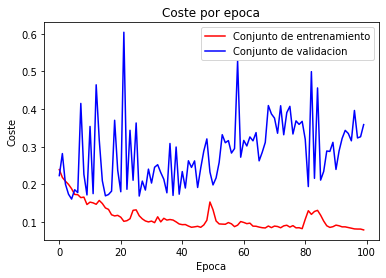

In [12]:
# Creacion del modelo

!pip install timm
import torchvision.models as models
import timm

# Creacion del modelo

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#model = models.alexnet(pretrained=True)
#model = models.densenet201(pretrained=True)
model = timm.create_model('inception_resnet_v2', pretrained=True)
basic_level_model = MyExtendedNet(model)

weights = original_weights

#loss_fn = nn.BCELoss()
loss_fn = nn.CrossEntropyLoss(weight = weights)
optimizer = torch.optim.Adam(basic_level_model.parameters(), lr = 0.001)
epochs = 100
if torch.cuda.is_available():
    basic_level_model.cuda()
    weights = torch.tensor(weights, device=device)
    loss_fn.cuda()
    device = "cuda"

# Entrenamiento y validacion

start_time = time.time()
training_cost, validation_cost = train_model_2(
    basic_level_model,
    optimizer,
    loss_fn, 
    train_dataloader, 
    val_dataloader,  
    epochs,
    device)
final_time = time.time() - start_time

#print("Estructura del modelo: \n", basic_level_model, "\n")
print('Tiempo de entrenamiento:', round(final_time/60, 3), " min \n")
plt.plot(range(epochs), training_cost, color = "r", label = "Conjunto de entrenamiento")
plt.plot(range(epochs), validation_cost, color = "b", label = "Conjunto de validacion")
plt.title("Coste por epoca")
plt.xlabel("Epoca")
plt.ylabel("Coste")
plt.legend()
plt.show()

In [13]:
# Prueba del modelo

start_time = time.time()
test_acc, test_pre, test_recall, test_F1, test_conf_mat = test_model_2(
    basic_level_model, 
    test_dataloader, 
    device)
final_time = time.time() - start_time
print('Tiempo de test:', round(final_time/60, 3), "\n")
print("Metricas del test:\n", "Exactitud: ", round(test_acc, 2), " Precision: ",
      round(test_pre, 2), " Recall: ", round(test_recall, 2), " F1: ", round(test_F1, 2), 
      "\n Matriz de Confusion: \n", test_conf_mat)

RuntimeError: ignored